# 2022-02-18 Householder QR

## Last time

* Stability and ill conditioning
* Intro to performance modeling
* Classical vs Modified Gram-Schmidt

## Today

* Performance strategies
* Right vs left-looking algorithms
* Elementary reflectors
* Householder QR

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

# A Gram-Schmidt with more parallelism

\begin{align}
(I - q_2 q_2^T) (I - q_1 q_1^T) v &= (I - q_1 q_1^T - q_2 q_2^T + q_2 q_2^T q_1 q_1^T) v \\
&= \Bigg( I - \Big[ q_1 \Big| q_2 \Big] \begin{bmatrix} q_1^T \\ q_2^T \end{bmatrix} \Bigg) v
\end{align}

In [2]:
function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

In [3]:
m = 10
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_classical(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 6.339875256299394e-11
norm(Q * R - A) = 1.217027619812654e-16


1.217027619812654e-16

# Why does order of operations matter?

\begin{align}
(I - q_2 q_2^T) (I - q_1 q_1^T) v &= (I - q_1 q_1^T - q_2 q_2^T + q_2 q_2^T q_1 q_1^T) v \\
&= \Bigg( I - \Big[ q_1 \Big| q_2 \Big] \begin{bmatrix} q_1^T \\ q_2^T \end{bmatrix} \Bigg) v
\end{align}
is not exact in finite arithmetic.

# We can look at the size of what's left over

We project out the components of our vectors in the directions of each $q_j$.

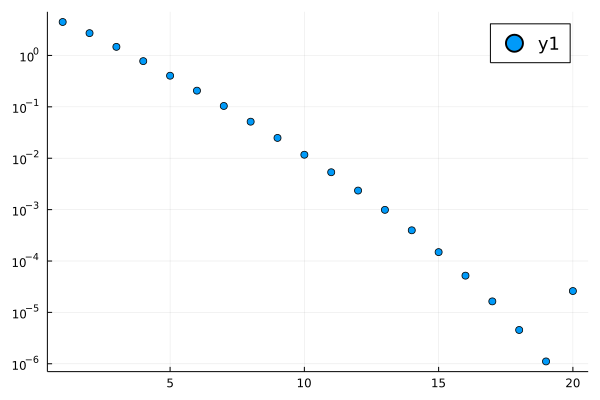

In [4]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, R = gram_schmidt_classical(A)
scatter(diag(R), yscale=:log10)

# The next vector is almost linearly dependent

norm(v) = 1.4245900685395503


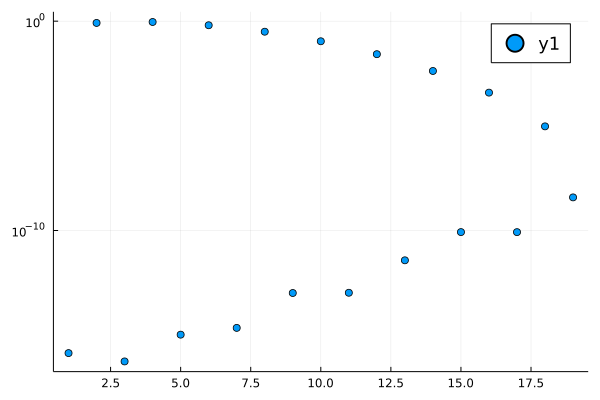

In [5]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, _ = gram_schmidt_classical(A)
#Q, _ = qr(A)
v = A[:,end]
@show norm(v)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10)

# Cost of Gram-Schmidt?

* We'll count flops (addition, multiplication, division*)
* Inner product $\sum_{i=1}^m x_i y_i$?
* Vector "axpy": $y_i = a x_i + y_i$, $i \in [1, 2, \dotsc, m]$.
* Look at the inner loop:
```julia
for k in 1:j-1
    r = Q[:,k]' * v
    v -= Q[:,k] * r
    R[k,j] = r
end
```

<img src="../img/flop-per-byte-dp.png" width="90%" />

# Counting flops is a bad model


* We load a single entry (8 bytes) and do 2 flops (add + multiply). That's an **arithmetic intensity** of 0.25 flops/byte.
* Current hardware can do about 10 flops per byte, so our best algorithms will run at about 2% efficiency.
* Need to focus on memory bandwidth, not flops.

## Dense matrix-matrix mulitply

* [BLIS project](https://github.com/flame/blis/)
* [Analytic modeling](https://www.cs.utexas.edu/users/flame/pubs/TOMS-BLIS-Analytical.pdf)

<img src="../img/blis-microkernel-stack.png" width="70%" />

# Inherent data dependencies

$$ \Bigg[ q_1 \Bigg| q_2 \Bigg| q_3 \Bigg| q_4 \Bigg| q_5 \Bigg] \begin{bmatrix} r_{11} & r_{12} & r_{13} & r_{14} & r_{15} \\
 & r_{22} & r_{23} & r_{24} & r_{25} \\
& & r_{33} & r_{34} & r_{35} \\
&&& r_{44} & r_{45} \\
&&& & r_{55}
\end{bmatrix}
$$

# Right-looking modified Gram-Schmidt

In [6]:
function gram_schmidt_modified(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(n, n)
    for j in 1:n
        R[j,j] = norm(Q[:,j])
        Q[:,j] /= R[j,j]
        R[j,j+1:end] = Q[:,j]'*Q[:,j+1:end]
        Q[:,j+1:end] -= Q[:,j]*R[j,j+1:end]'
    end
    Q, R
end

gram_schmidt_modified (generic function with 1 method)

In [7]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_modified(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 8.486718528276085e-9
norm(Q * R - A) = 8.709998074379606e-16


8.709998074379606e-16

# Classical versus modified?

* Classical
  * Really unstable, orthogonality error of size $1 \gg \epsilon_{\text{machine}}$
  * Don't need to know all the vectors in advance
* Modified
  * Needs to be right-looking for efficiency
  * Less unstable, but orthogonality error $10^{-9} \gg \epsilon_{\text{machine}}$

In [8]:
m = 10
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = qr(A)
@show norm(Q' * Q - I)

norm(Q' * Q - I) = 2.1776697623015113e-15


2.1776697623015113e-15

# Householder QR

Gram-Schmidt constructed a triangular matrix $R$ to orthogonalize $A$ into $Q$. Each step was a projector, which is a rank-deficient operation. Householder uses orthogonal transformations (reflectors) to triangularize.

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

The structure of the algorithm is

$$ \underbrace{\begin{bmatrix} * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ \end{bmatrix}}_{A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ \end{bmatrix}}_{Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & * \\ 0 & 0 & * \\ \end{bmatrix}}_{Q_2 Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ \end{bmatrix}}_{Q_3 Q_2 Q_1 A}
$$

# Constructing the $Q_j$

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

Each of our $Q_j$ will have the form
$$Q_j = \begin{bmatrix} I_i & 0 \\ 0 & F \end{bmatrix}$$
where $F$ is a "reflection" that achieves
$$ F x = \begin{bmatrix} \lVert x \rVert \\ 0 \\ 0 \\ \vdots \end{bmatrix} $$
where $x$ is the column of $R$ from the diagonal down.
This transformation is a reflection across a plane with normal $v = Fx - x = \lVert x \rVert e_1 - x$.

![Householder Reflector (Trefethen and Bau, 1999)](../img/TB-Householder.png)

The reflection, as depicted above by Trefethen and Bau (1999) can be written $F = I - 2 \frac{v v^T}{v^T v}$.

# Adventures in reflection

In [9]:
A = rand(4, 4); A += A'
v = copy(A[:,1])
v[1] -= norm(v)
v = normalize(v)
F = I - 2 * v * v'
B = F * A

v = copy(B[2:end, 2])
v[1] -= norm(v); v = normalize(v)
F = I - 2 * v * v'
B[2:end, 2:end] = F * B[2:end, 2:end]
B

4×4 Matrix{Float64}:
  1.86401       2.2205       1.75312    1.52718
  1.04161e-17   0.982175     0.901202   0.133707
  1.6015e-16   -9.71445e-17  0.12403   -0.95277
 -1.59097e-17   0.0          1.44374    0.08136

# An algorithm

In [10]:
function qr_householder_naive(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] -= norm(v)
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * (v' * R[j:end,j:end])
        push!(V, v)
    end
    V, R
end

qr_householder_naive (generic function with 1 method)

In [11]:
m = 4
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
_, R_ = qr(A)
R_

4×4 Matrix{Float64}:
 -2.0  0.0      -1.11111      0.0
  0.0  1.49071   1.38778e-17  1.3582
  0.0  0.0       0.888889     9.71445e-17
  0.0  0.0       0.0          0.397523

# How to interpret $V$ as $Q$?

In [12]:
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

function reflectors_to_dense(V)
    m = length(V[1])
    Q = diagm(ones(m))
    for j in 1:m
        Q[:,j] = reflectors_mult(V, Q[:,j])
    end
    Q
end

reflectors_to_dense (generic function with 1 method)

In [13]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 3.7994490775439526e-15
norm(Q * R - A) = 7.562760794606217e-15


# Great, but we can still break it

In [14]:
A = [1 0; 0 1.]
V, R = qr_householder_naive(A)

(Any[[NaN, NaN], [NaN]], [NaN NaN; NaN NaN])

We had the lines

```julia
    v = copy(R[j:end, j])
    v[1] -= norm(v)
    v = normalize(v)
```
What happens when `R` is already upper triangular?

![Choosing the better of two Householder reflectors (Trefethen and Bau, 1999).](../img/TB-Householder2.png)

# An improved algorithm



In [15]:
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

In [16]:
A = [2 -1; -1 2] * 1e-10
V, R = qr_householder(A)
tau = [2*v[1]^2 for v in V]
@show tau
V1 = [v ./ v[1] for v in V]
@show V1
R

tau = [1.894427190999916, 2.0]
V1 = [[1.0, -0.2360679774997897], [1.0]]


2×2 Matrix{Float64}:
 -2.23607e-10   1.78885e-10
 -1.29247e-26  -1.34164e-10

# Householder is backward stable

In [17]:
m = 40
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 5.949301496893686e-15
norm(Q * R - A) = 1.2090264267288813e-14


In [18]:
A = [1 0; 0 1.]
V, R = qr_householder(A)
qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}}
Q factor:
2×2 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}}:
 1.0  0.0
 0.0  1.0
R factor:
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

# Orthogonality is preserved

norm(v) = 1.4245900685395503


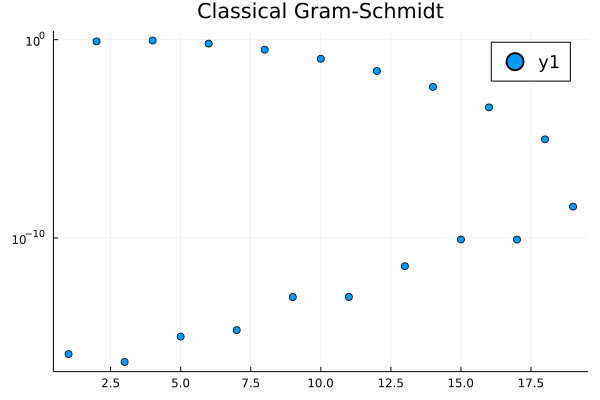

In [24]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, _ = gram_schmidt_classical(A)
v = A[:,end]
@show norm(v)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Classical Gram-Schmidt")

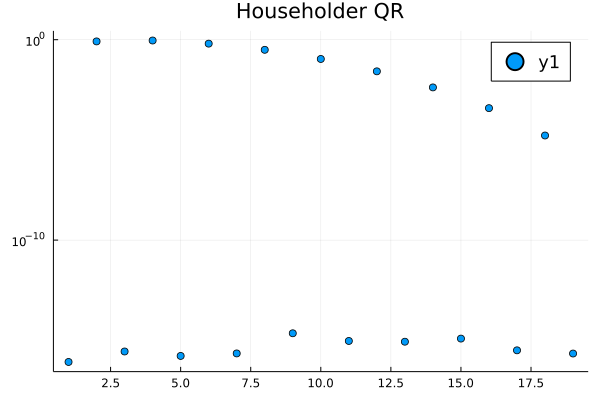

In [25]:
Q = reflectors_to_dense(qr_householder(A)[1])
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Householder QR")